In [1]:
import pandas as pd
import numpy as np

In [2]:
def state_propagation(q0, prob_transition_matrix, n_steps):
    q = q0.copy()
    for _ in range(n_steps):
        q = M @ q
    return q

In [73]:
# 1 - state propagation

M = pd.read_csv('M.csv', header=None)
t = 1024
q0 = [1,0,0,0,0,0,0,0,0,0]

print([round(node, ndigits=5) for node in state_propagation(q0, M, t)])

[0.05103, 0.04374, 0.12806, 0.18613, 0.08748, 0.11726, 0.0885, 0.08319, 0.11726, 0.09735]


In [13]:
# 1 - random walk
def random_walk(q0, prob_transition_matrix, n_burn_in_steps, n_steps_after_burn_in):
    #q0 should be all 0s except one 1
    M = prob_transition_matrix.copy()
    i = q0.index(1)
    node_options = np.arange(M.shape[0])
    
    for _ in range(n_burn_in_steps):
        i = np.random.choice(node_options, p=M[i].to_numpy())

    num_times_at_each_node = np.zeros(M.shape[0])
    for _ in range(n_steps_after_burn_in):
        i = np.random.choice(node_options, p=M[i].to_numpy())
        num_times_at_each_node[i] += 1

    q_star = num_times_at_each_node / num_times_at_each_node.sum()
    return q_star

In [71]:
M = pd.read_csv('M.csv', header=None)
t = 1024
q0 = [1,0,0,0,0,0,0,0,0,0]
burn_in = 100

print([round(float(node), ndigits=5) for node in random_walk(q0, M, burn_in, t)])

[0.05859, 0.05664, 0.10449, 0.15234, 0.06738, 0.10059, 0.11719, 0.09375, 0.14551, 0.10352]


In [66]:
# 1 - eigenanalysis

M_np = np.asarray(M, dtype=float)
evals, evecs = np.linalg.eig(M_np)
first_eval = np.argmin(np.abs(evals - 1))
first_evec = evecs[:, first_eval].real
q_star = first_evec / np.sum(first_evec)
print([round((float(node)), ndigits=5) for node in q_star])

[0.05103, 0.04374, 0.12806, 0.18613, 0.08748, 0.11726, 0.0885, 0.08319, 0.11726, 0.09735]


In [88]:
# B

sp_one_at_zero = np.array(state_propagation([1,0,0,0,0,0,0,0,0,0], M, 1024))
true_answer = q_star
needs_to_be_this_close = np.abs(sp_one_at_zero - true_answer)

q0 = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])

how_close = np.array([1/len(q0)]*len(q0))
steps = 0
q = q0.copy()
while not np.all(how_close <= needs_to_be_this_close):
    q = M @ q
    how_close = np.abs(q - true_answer)
    steps += 1

print(q)
print(f'\n{how_close}')
print(f'\n{steps}')

0    0.051031
1    0.043740
2    0.128057
3    0.186130
4    0.087481
5    0.117262
6    0.088499
7    0.083189
8    0.117262
9    0.097349
dtype: float64

0    6.522560e-16
1    6.800116e-16
2    1.942890e-16
3    8.881784e-16
4    2.081668e-16
5    6.800116e-16
6    1.054712e-15
7    1.082467e-15
8    1.484923e-15
9    1.235123e-15
dtype: float64

683


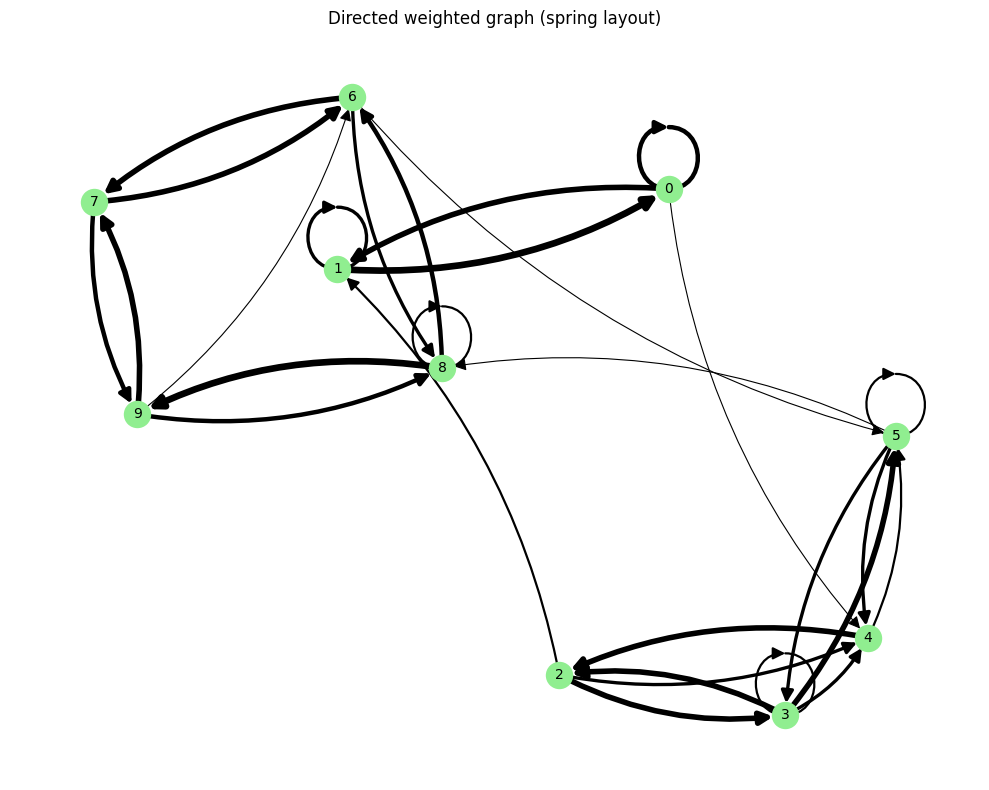

<Figure size 640x480 with 0 Axes>

In [129]:
# bonus

import networkx as nx
import matplotlib.pyplot as plt

A = M_np

n = A.shape[0]
G = nx.DiGraph()

# add nodes
G.add_nodes_from(range(n))

# add edges only where weight > 0
for src in range(n):
    for dst in range(n):
        w = A[src, dst]   # note: this assumes A[src,dst] = weight of edge src -> dst
        if w > 0:
            G.add_edge(src, dst, weight=w)

# layout (force-directed)
pos = nx.spring_layout(G, seed=1, k=0.8)   # seed for reproducibility

# draw nodes and labels
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=350, node_color='lightgreen')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='normal')

# prepare edge widths from weights (scale factor chosen for visibility)
weights = np.array([d['weight'] for u, v, d in G.edges(data=True)])
widths = weights * 8  # tweak the multiplier for thicker/thinner lines

# draw directed edges (arrows)
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>', arrowsize=18,
    width=widths,
    connectionstyle='arc3,rad=0.16'  # small curvature helps show direction on bidirectional edges
)

# draw edge labels (weights)
#edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.axis('off')
plt.title("Directed weighted graph (spring layout)")
plt.tight_layout()
plt.show()

# Optionally save the figure:
plt.savefig("directed_weighted_graph.png", dpi=300)